In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("C://Users/matth/Downloads/310_23498_compressed_creditcard.csv/creditcard.csv")

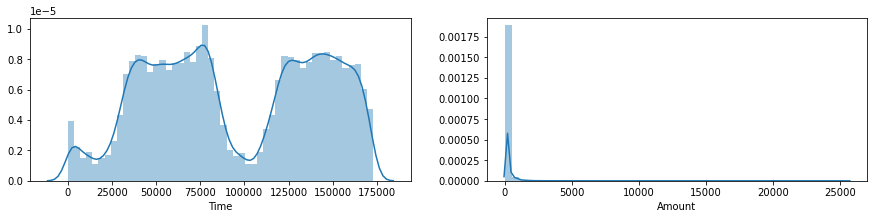

In [3]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.distplot(df.Time)
plt.subplot(1,2,2)
sns.distplot(df.Amount)

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler=RobustScaler()

df["scaled_time"]=scaler.fit_transform(df["Time"].values.reshape(-1,1))
df["scaled_amount"]=scaler.fit_transform(df["Amount"].values.reshape(-1,1))

In [6]:
df.drop(["Time","Amount"],axis=1,inplace=True)

In [177]:
small_df=df.sample(n=16000)
X=small_df.drop(["Class"],axis=1)
y=small_df["Class"]

In [178]:
#This cell is not needed if we are not over/undersampling. I'll try without over/under as the score becomes too high
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
over=RandomOverSampler(sampling_strategy=0.2)
#under=RandomUnderSampler(sampling_strategy=0.1)
#X,y=under.fit_resample(X,y)
#print(Counter(y))
#X,y=over.fit_resample(X,y)
#print(Counter(y))
X.shape,y.shape,Counter(y)

((16000, 30), (16000,), Counter({0: 15974, 1: 26}))

In [179]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
train_set = lgb.Dataset(data = X_train, label = y_train)
test_set = lgb.Dataset(data = X_test, label = y_test)

In [180]:
model=lgb.LGBMClassifier()
default_params=model.get_params()
del default_params["n_estimators"]
cv_results=lgb.cv(default_params,train_set,num_boost_round=10000,early_stopping_rounds=100,metrics='auc',seed=42)
print("Baseline AUC score without tuning is {:.5f}".format(cv_results['auc-mean'][-1]))
print("Baseline boosting rounds are {}".format(len(cv_results['auc-mean'])))

Baseline AUC score without tuning is 0.89823
Baseline boosting rounds are 32


In [181]:
model.n_estimators=len(cv_results['auc-mean'])
model.fit(X_train,y_train)
pred=model.predict_proba(X_test)[:,1]
roc_auc_score(y_test,pred)

0.7637280976220275

In [183]:
# I need a function that eats a parameter set and spits out a score
def objective(hyperparameters,iteration):
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters["n_estimators"]
    cv_results=lgb.cv(hyperparameters,train_set,num_boost_round=10000,early_stopping_rounds=100,metrics='auc',seed=42)
    score=cv_results['auc-mean'][-1]
    estimators=len(cv_results['auc-mean'])
    hyperparameters['n_estimators']=estimators
    return [score,hyperparameters,iteration]

In [187]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [207]:
import random
random.seed(50)
boosting_type=random.sample(param_grid['boosting_type'],1)[0]
subsample=1.0 if boosting_type=="goss" else random.sample(param_grid['subsample'],1)[0]
print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


In [212]:
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(5)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(5)))

In [237]:
#I need a function that eats many sets of parameters and spits out every score (stored in a DataFrame),
#then chooses the best parameter set
import itertools

def grid_search(param_grid,max_eval=5):
    results=pd.DataFrame(columns=["score","params","iteration"],index=list(range(5)))
    keys,values=zip(*param_grid.items())
    i=0
    for v in itertools.product(*values):
        hyperparameters=dict(zip(keys,v))
        hyperparameters["subsample"]=1.0 if hyperparameters['boosting_type']=='goss' else hyperparameters['subsample']
        eval_results=objective(hyperparameters,i)
        results.loc[i,:]=eval_results
        i+=1
        if i>5:
            break
    results.sort_values("score",ascending=False,inplace=True)
    results.reset_index(inplace=True)
    return results
        

In [244]:
new_params=grid_search(param_grid).loc[0,'params']

In [269]:
new_model=lgb.LGBMClassifier(param_grid=new_params,random_state=42)
cv_results=lgb.cv(new_params,train_set,num_boost_round=10000,early_stopping_rounds=100,metrics='auc',seed=42)
cv_results['auc-mean'][-1]

0.9115042699117076

In [276]:
new_model=lgb.LGBMClassifier(**new_params)
new_model.fit(X_train,y_train)
pred=new_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test,pred)

0.6060700876095119

In [268]:
new_params,default_params

({'boosting_type': 'gbdt',
  'num_leaves': 20,
  'learning_rate': 0.004999999999999999,
  'subsample_for_bin': 20000,
  'min_child_samples': 20,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'colsample_bytree': 0.6,
  'subsample': 0.5,
  'is_unbalance': True,
  'n_estimators': 173},
 {'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': 1.0,
  'importance_type': 'split',
  'learning_rate': 0.1,
  'max_depth': -1,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_jobs': -1,
  'num_leaves': 31,
  'objective': None,
  'random_state': None,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'silent': True,
  'subsample': 1.0,
  'subsample_for_bin': 200000,
  'subsample_freq': 0,
  'n_estimators': 32})

In [13]:
top_v=abs(new_df.corr()["Class"]).sort_values(ascending=False)[1:10].index

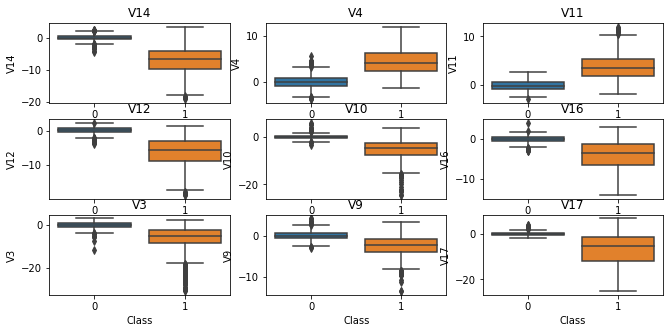

In [14]:
plt.figure(figsize=(11,5))
x=1
for col in top_v:
    plt.subplot(3,3,x)
    sns.boxplot(x="Class",y=col,data=new_df)
    plt.title(col)
    x=x+1

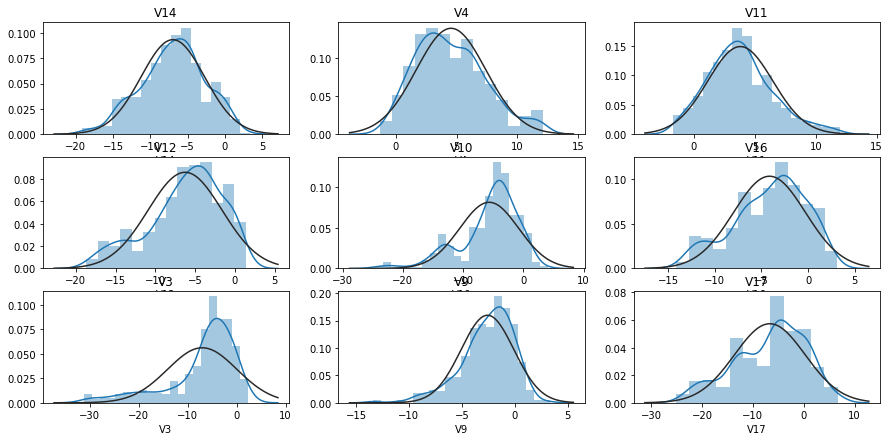

In [15]:
from scipy.stats import norm
plt.figure(figsize=(15,7))
x=1
for col in top_v:
    plt.subplot(3,3,x)
    sns.distplot(new_df[new_df["Class"]==1][col],fit=norm)  
    plt.title(col)
    x=x+1

In [16]:
#Removing outliers from fraud data.. not too sure why
fraud_df=new_df[new_df["Class"]==1]
outlier_df=pd.DataFrame(columns=new_df.columns)

for x in ["V14","V12","V10"]:
    IQR= (np.percentile(fraud_df[x],75)-np.percentile(fraud_df[x],25))*1.5
    lower_limit=np.percentile(fraud_df[x],25)-IQR
    upper_limit=np.percentile(fraud_df[x],75)+IQR
    outlier_df=outlier_df.append(fraud_df[(fraud_df[x]<=lower_limit) | (fraud_df[x]>=upper_limit)])
    #print(new_df[(new_df[x]<=lower_limit) | (new_df[x]>=upper_limit)].shape)
    #outlier_df=pd.concat([outlier_df,new_df[(new_df[x]<=lower_limit) & (new_df[x]<=upper_limit)]])
    

In [17]:
new_df.drop(outlier_df.drop_duplicates().index,inplace=True)

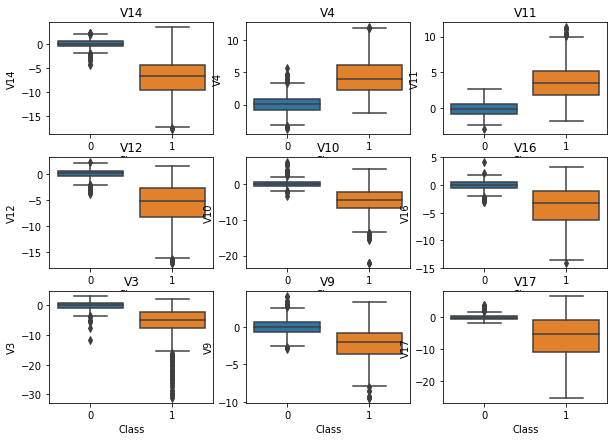

In [18]:
plt.figure(figsize=(10,7))
x=1
for col in top_v:
    plt.subplot(3,3,x)
    sns.boxplot(x="Class",y=col,data=new_df)
    plt.title(col)
    x=x+1

In [19]:
X=new_df.drop("Class",axis=1)
Y=new_df["Class"]
t0=time.time()
X_reduced_tsne=TSNE(n_components=2,random_state=42).fit_transform(X.values)
t1=time.time()
print("TSNE took {:.2}s".format(t1-t0))
t0=time.time()
X_reduced_pca=PCA(n_components=2,random_state=42).fit_transform(X)
t1=time.time()
print("PCA took {:.2}s".format(t1-t0))
t0=time.time()
X_reduced_SVD=TruncatedSVD(n_components=2,random_state=42,algorithm="randomized").fit_transform(X)
t1=time.time()
print("SVD took {:.2}s".format(t1-t0))

TSNE took 6.8s
PCA took 0.042s
SVD took 0.01s


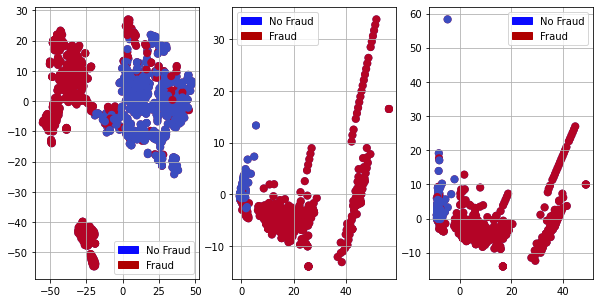

In [20]:
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
#sns.scatterplot(x=X_reduced_tsne[:,0],y=X_reduced_tsne[:,1],palette=(Y==0))
#sns.scatterplot(x=X_reduced_tsne[:,0],y=X_reduced_tsne[:,1],palette=(Y==1))
plt.scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1],c=(Y==0),cmap="coolwarm",label="No Fraud",linewidths=2)
plt.scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1],c=(Y==1),cmap="coolwarm",label="Fraud",linewidths=2)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])

plt.subplot(1,3,2)
plt.scatter(X_reduced_SVD[:,0],X_reduced_SVD[:,1],c=(Y==0),cmap="coolwarm",label="No Fraud",linewidths=2)
plt.scatter(X_reduced_SVD[:,0],X_reduced_SVD[:,1],c=(Y==1),cmap="coolwarm",label="Fraud",linewidths=2)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])

plt.subplot(1,3,3)
plt.scatter(X_reduced_pca[:,0],X_reduced_pca[:,1],c=(Y==0),cmap="coolwarm",label="No Fraud",linewidths=2)
plt.scatter(X_reduced_pca[:,0],X_reduced_pca[:,1],c=(Y==1),cmap="coolwarm",label="Fraud",linewidths=2)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key,classifier in classifiers.items():
    classifier.fit(X_train,Y_train)
    training_score=cross_val_score(classifier,X_train,Y_train,cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


In [34]:
from sklearn.model_selection import GridSearchCV

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg=GridSearchCV(LogisticRegression(),log_reg_params)
grid_log_reg.fit(X_train,Y_train)
log_reg=grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, Y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, Y_train)

svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, Y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_


In [35]:
# Overfitting Case
log_reg_score = cross_val_score(log_reg, X_train, Y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, Y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, Y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, Y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  93.62%
Knears Neighbors Cross Validation Score 93.49%
Support Vector Classifier Cross Validation Score 93.23%
DecisionTree Classifier Cross Validation Score 91.8%


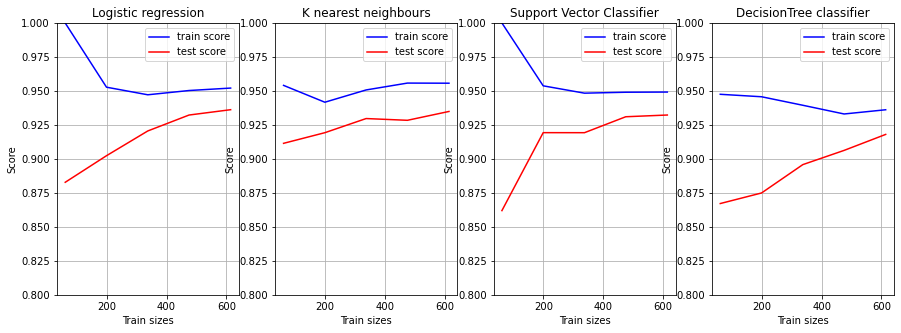

In [36]:
from sklearn.model_selection import learning_curve
models={"Logistic regression": log_reg,"K nearest neighbours": knears_neighbors,"Support Vector Classifier":
        svc,"DecisionTree classifier":tree_clf}
x=1
plt.figure(figsize=(15,5))
for key, model in models.items():
    train_sizes, train_scores, test_scores=learning_curve(model,X_train,Y_train)
    plt.subplot(1,4,x)
    plt.plot(train_sizes,train_scores.mean(axis=1),color="b",label="train score")
    plt.plot(train_sizes,test_scores.mean(axis=1),color="r",label="test score")
    plt.xlabel("Train sizes"),plt.ylabel("Score"),plt.grid(True),plt.legend(loc="best"),plt.ylim((0.8,1)),plt.title(key)

    x=x+1

(Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate'))

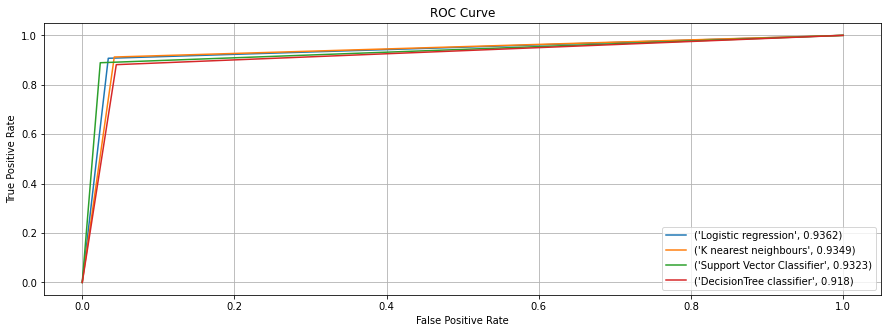

In [37]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict


plt.figure(figsize=(15,5))
for key, model in models.items():
    
    Y_predict=cross_val_predict(model,X_train,Y_train)
    fpr,tpr,thresholds=roc_curve(Y_train,Y_predict)
    plt.plot(fpr,tpr,label=(key,round(cross_val_score(model, X_train, Y_train).mean(),4)))
plt.legend(loc="best"),plt.grid(True), plt.title("ROC Curve")
plt.xlabel('False Positive Rate', fontsize=10), plt.ylabel('True Positive Rate', fontsize=10)
    

In [38]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
Y_ave=pd.DataFrame()

for key, model in models.items():
    Y_ave[key]=cross_val_predict(model,X_train,Y_train)
    print(f'{key} R2 is: ' + str(round(accuracy_score(Y_train,Y_ave[key]),3)))
Y_ave["Average"]=Y_ave.mean(axis=1)
Y_ave["predict"]=Y_ave["Average"].map(lambda x: 1 if x>=0.5 else 0)

print("R2 for averaged models is: ", str(round(accuracy_score(Y_train,Y_ave["predict"]),3)))

Logistic regression R2 is: 0.936
K nearest neighbours R2 is: 0.935
Support Vector Classifier R2 is: 0.932
DecisionTree classifier R2 is: 0.918
R2 for averaged models is:  0.94


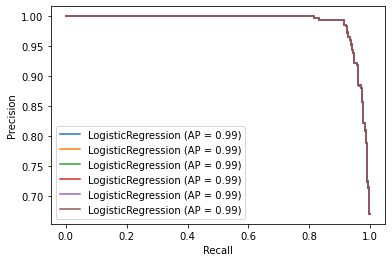

In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
C=[0.01,0.1,1,10,100,1000]

fig,ax=plt.subplots()
for c in C:
    lr=LogisticRegression(class_weight={0:1,1:c})
    lr.fit(X_train,Y_train)
    pred_prob=log_reg.predict_proba(X_test)[:,1]
    precision_recall_curve(Y_test,pred_prob)
    plot_precision_recall_curve(log_reg,X_train,Y_train,response_method='predict_proba',ax=ax)